 <h1 align="center">Final_Project_Brain_Tumor_Classifier</h1>

 <h3 align="center">Authors: Noa Mansbach & Ido Shapira</h3>   

#### Project Overview and Objective:
- The main purpose of this project was to build models that would classify if a subject has a tumor or not based on an MRI scan. The model would try to learn the pattern of Brain Tumor in the MRI scans with different conditions such as - brain shape, size of the tumor etc.
- In addition, we would like to test whether we can, after training a model, develop an application that, given an image, will be able to classify whether a person has a brain tumor or not, so that it will be open for use by each doctor.

#### Data-Set Description:
The image data that was used for this problem is Brain MRI Images for Brain Tumor Detection from Kaggle web. It consists 253 MRI scans of two classes:
* NO - no tumor, encoded as 0 - 98 images
* YES - tumor, encoded as 1 - 155 images

#### Our Techniques: 
We will build a number of models based on different learning techniques some of which we learned in the course during the semester.
1. KNN model - finding a K-nearby neighbor.
2. SVM model - Support Vector Machine
3. Random Forest model - a forest of decision trees.
4. CNN model - a technique we learned in the "deep learning" course that we think will give good results on the database.


## Code:

### Import all the necessary libraries:
We have used Python libraries:
- sklearn
- tensorflow

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from tqdm import tqdm
import random as rn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
# ! pip install split-folders
import splitfolders

import matplotlib.pyplot as plt
import seaborn as sns

## fix random seed:

In [3]:
rs = 42 # random seed
np.random.seed(rs)
rn.seed(rs)

# Import the data:

In [4]:
X = []
Z = []
IMG_SIZE=150

NO_DIR='./data/brain_tumor_dataset/no'
YES_DIR='./data/brain_tumor_dataset/yes'

We face up with dataset that contains both RGB and gray scale images, therefore we decided to convert all images to be gray scale.

In [5]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        np_img=np.asarray(img)
        X.append(np_img)
        Z.append(str(label))

In [6]:
# make 'No' data
make_train_data('No',NO_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:02<00:00, 39.00it/s]

98


In [7]:
# make 'Yes' data
make_train_data('Yes',YES_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:03<00:00, 41.43it/s]

253


Description of the data:
1. Number of instances: 253
2. Number of attributes: 240*240

## Check some image

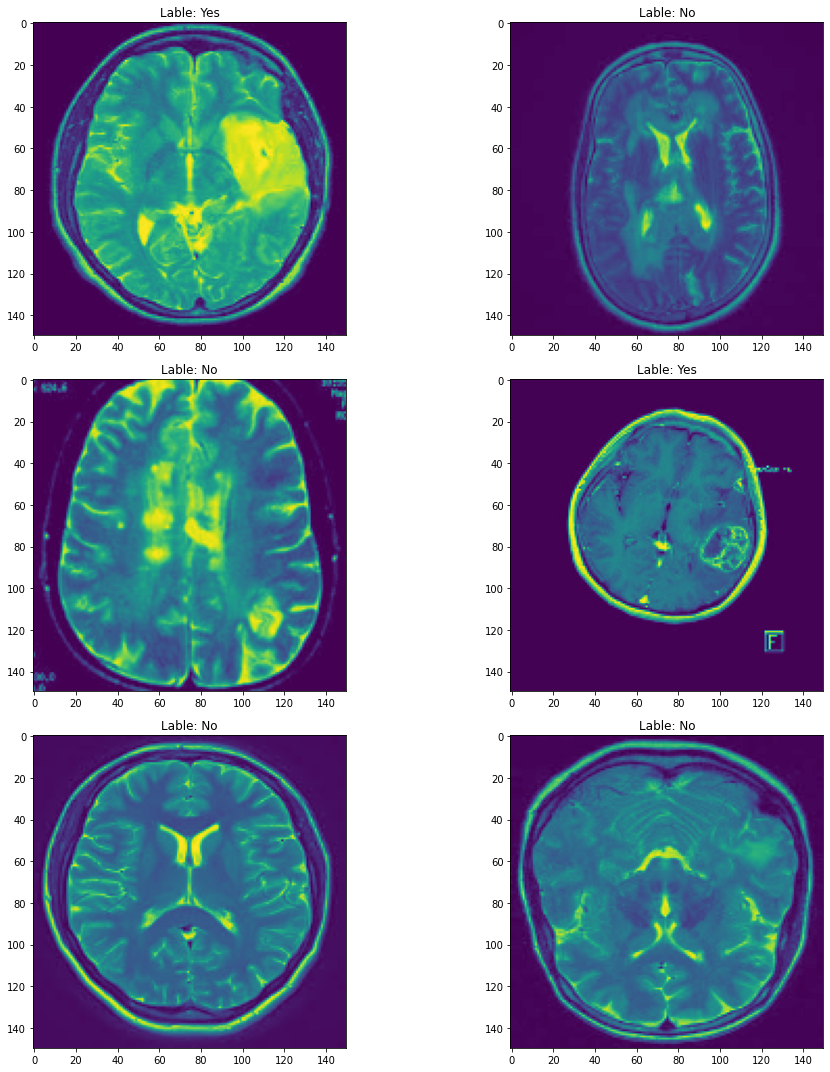

In [8]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Lable: '+Z[l])
        
plt.tight_layout()

We note that some of the images have large black areas arrond the brain scan, thus we decided to crop the image such that only the brain scan would remain.

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        
        
        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [9]:
# def crop_brain_contour(image):
#     blur_image = cv2.GaussianBlur(image, (5, 5), 0)
#     # Canny Edge Detection Algortihm from OpenCV
#     thresh = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
#     thresh = cv2.erode(thresh, None, iterations=2)
#     thresh = cv2.dilate(thresh, None, iterations=2)
    
# #     im_bw = cv2.Canny(blur_image, 10, 90)
#     contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#     # Find contours in thresholded image, then grab the largest one
#     cnts = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
#     # crop new image out of the original image using the four extreme points (left, right, top, bottom)
#     for c in cnts:
#         x,y,w,h = cv2.boundingRect(c)
#         new_image = image[y:y+h, x:x+w]
#         break        
    
#     return new_image

In [10]:
# for i in range(len(X)):
#     X[i] = crop_brain_contour(X[i])

In [11]:
# # check some image
# fig,ax=plt.subplots(3,2)
# fig.set_size_inches(15,15)
# for i in range(3):
#     for j in range (2):
#         l=rn.randint(0,len(Z))
#         ax[i,j].imshow(X[l])
#         ax[i,j].set_title('Lable: '+Z[l])
        
# plt.tight_layout()

### Label encoding:

'No' = 0

'Yes' = 1

In [12]:
Y = np.array(Z)
Y = np.where(Y=='No', 0, Y)
Y = np.where(Y=='Yes', 1, Y)
Y = Y.astype('int32')

### Normalization and flatten the images:

In [13]:
X = np.array([cv2.normalize(X[i], None, 0, 255, cv2.NORM_MINMAX) for i in range(len(X))]) # normalization
X=np.array(X)/255
# X = X.flatten().reshape(len(X), (IMG_SIZE ** 2) * 3) # 3 is because it is RGB image 
X = X.flatten().reshape(len(X), (IMG_SIZE ** 2))

### Our dataset:

In [14]:
df = pd.DataFrame(data=X)
df

,0,1,2,3,4,5,6,7,8,9,...,22490,22491,22492,22493,22494,22495,22496,22497,22498,22499
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.125490,0.054902,0.078431,0.058824,0.070588,0.058824,0.058824,0.058824,0.058824,0.058824,...,0.070588,0.070588,0.070588,0.070588,0.070588,0.070588,0.070588,0.070588,0.070588,0.125490
249,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
250,0.360784,0.533333,0.501961,0.447059,0.494118,0.482353,0.482353,0.494118,0.494118,0.486275,...,0.470588,0.474510,0.474510,0.474510,0.474510,0.474510,0.478431,0.600000,0.486275,0.462745
251,0.000000,0.000000,0.000000,0.000000,0.003922,0.003922,0.003922,0.007843,0.011765,0.027451,...,0.552941,0.552941,0.552941,0.549020,0.552941,0.556863,0.109804,0.086275,0.113725,0.117647


### Train-Test Split:

In [15]:
# separate data
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=rs, shuffle=True)

freqs = pd.DataFrame({"Training dataset": [(y_train == 1).sum(),(y_train == 0).sum()],
                      "Test dataset": [(y_test == 1).sum(),(y_test == 0).sum()],
                      "Total": [(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 0).sum()+(y_test == 0).sum()]},
                     index=["Free", "Full"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
Free,124,31,155
Full,78,20,98


In [16]:
def statistics(confusion):
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print('True Positives (TP):',TP)
    print('True Negatives (TN):',TN)
    print('False Positives (FP):',FP)
    print('False Negarives (FN):',FN)
    print('Classification Accuracy:',(TP + TN) / float(TP + TN + FP + FN))
    precision = TN / float(TN + FP)
    print('Precision:',precision)
    recall = TP / float(TP + FN)
    print('Recall:', recall)
    print('f-score:', 2 * precision * recall / (precision + recall))

In [17]:
def cm_analysis(y_true, y_pred, labels, figsize=(7,6)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_result = pd.DataFrame(cm, index=labels, columns=labels)
    cm_result.index.name = 'Actual'
    cm_result.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Blues')
    #plt.savefig(filename)
    plt.show()
    return cm_result, cm

# Using Support Vector Machine (SVM)

In [18]:
# Create a svm classifier:
param_grid = [
  {'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear', 'sigmoid']},
 ]
svc = SVC()
svc_classifier = GridSearchCV(svc, param_grid, verbose = 1)
svc_classifier.fit(X_train, y_train)
#fit to the training data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  3.0min finished


GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100],
                          'kernel': ['rbf', 'linear', 'sigmoid']}],
             verbose=1)

### the best parameters for the model:

In [19]:
print(svc_classifier.best_score_)
print(svc_classifier.best_params_)

0.7869512195121952
{'C': 10, 'kernel': 'rbf'}


### Prediction:

In [20]:
y_pred = svc_classifier.predict(X_test)

### Confusion matrix and result report:

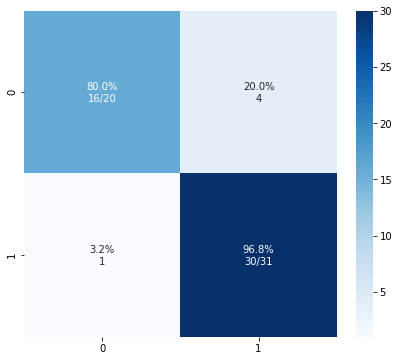

In [21]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [22]:
statistics(cm)

True Positives (TP): 30
True Negatives (TN): 16
False Positives (FP): 4
False Negarives (FN): 1
Classification Accuracy: 0.9019607843137255
Precision: 0.8
Recall: 0.967741935483871
f-score: 0.8759124087591241


# Using k-nearest neighbors (KNN)

In [23]:
# Create a knn classifier:
param_grid = [
  {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance']},
 ]
knn = KNeighborsClassifier()
knn_classifier = GridSearchCV(knn, param_grid, verbose = 1)
knn_classifier.fit(X_train,y_train)
#fit to the training data

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.1min finished


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

### the best parameters for the model:

In [24]:
print(knn_classifier.best_score_)
print(knn_classifier.best_params_)

0.7921951219512195
{'n_neighbors': 7, 'weights': 'distance'}


### Prediction:

In [25]:
y_pred = knn_classifier.predict(X_test)

### Confusion matrix and result report:

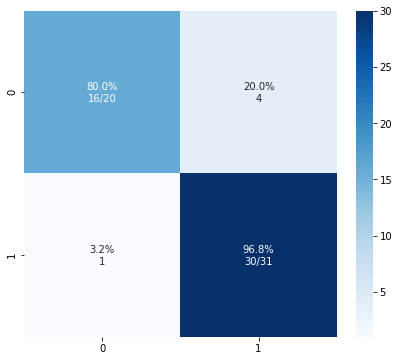

In [26]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [27]:
statistics(cm)

True Positives (TP): 30
True Negatives (TN): 16
False Positives (FP): 4
False Negarives (FN): 1
Classification Accuracy: 0.9019607843137255
Precision: 0.8
Recall: 0.967741935483871
f-score: 0.8759124087591241


# Using Random Forest model

In [28]:
# Create a Random Forest classifier:
param_grid = { 
    'n_estimators': [10,50,100,200,500],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier()
rfc_classifier = GridSearchCV(rfc, param_grid, verbose = 1)
rfc_classifier.fit(X_train,y_train)
#fit to the training data

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200, 500]},
             verbose=1)

### the best parameters for the model:

In [29]:
print(rfc_classifier.best_score_)
print(rfc_classifier.best_params_)

0.8165853658536586
{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 50}


### Prediction:

In [30]:
y_pred = rfc_classifier.predict(X_test)

### Confusion matrix and result report:

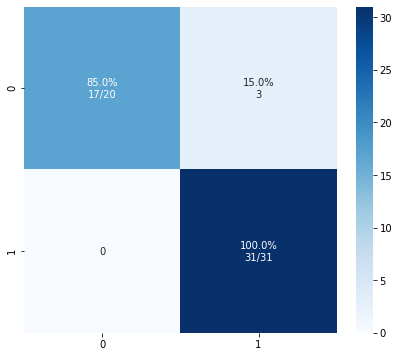

In [31]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [32]:
statistics(cm)

True Positives (TP): 31
True Negatives (TN): 17
False Positives (FP): 3
False Negarives (FN): 0
Classification Accuracy: 0.9411764705882353
Precision: 0.85
Recall: 1.0
f-score: 0.9189189189189189


# Using Deep Learning method - CNN

## Part 1 - Data Preprocessing

## Split into train , test data

In [33]:
# train, test split
splitfolders.ratio('./data/brain_tumor_dataset/', output="./data/brain_tumor_dataset_split", ratio=(0.7, 0.3))

Copying files: 253 files [00:00, 532.88 files/s]


### Preprocessing the Training set

In [34]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train = train_datagen.flow_from_directory('./data/brain_tumor_dataset_split/train',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 183 images belonging to 2 classes.


In [35]:
train.class_indices

{'no': 0, 'yes': 1}

In [36]:
yes=np.count_nonzero(train.classes)
print("Yes:",yes)
print("No:",176-yes)

Yes: 108
No: 68


### Preprocessing the Test set

In [37]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test = test_datagen.flow_from_directory('data/brain_tumor_dataset_split/val/',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 84 images belonging to 2 classes.


In [38]:
yes_test=np.count_nonzero(test.classes)
print("Yes:",yes_test)
print("No:",77-yes_test)

Yes: 47
No: 30


In [39]:
len(test.classes)

84

https://www.kaggle.com/brendonim/brain-mri-tumor-detection-using-svm

## Part 2 - Building the CNN

In [40]:
### Init the CNN model
cnn = tf.keras.models.Sequential()

### Convolution and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=[64,64,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Flattening
cnn.add(tf.keras.layers.Flatten())

### Fully Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Training the CNN

### Compiling the CNN

In [41]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Summary of the model

In [42]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 32)        4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

### Training the CNN on the Training set and evaluating it on the Test set

In [56]:
history=cnn.fit(x = train, epochs = 121 ,validation_data=test)

Epoch 1/121
6/6 [==============================] - 1s 206ms/step - loss: 0.0312 - accuracy: 0.9891 - val_loss: 1.1683 - val_accuracy: 0.8571
Epoch 2/121
6/6 [==============================] - 1s 192ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.8742 - val_accuracy: 0.8333
Epoch 3/121
6/6 [==============================] - 1s 206ms/step - loss: 0.0507 - accuracy: 0.9781 - val_loss: 1.1848 - val_accuracy: 0.8214
Epoch 4/121
6/6 [==============================] - 1s 231ms/step - loss: 0.1755 - accuracy: 0.9454 - val_loss: 1.0806 - val_accuracy: 0.8452
Epoch 5/121
6/6 [==============================] - 1s 184ms/step - loss: 0.2645 - accuracy: 0.9290 - val_loss: 0.6597 - val_accuracy: 0.8452
Epoch 6/121
6/6 [==============================] - 1s 212ms/step - loss: 0.1758 - accuracy: 0.9399 - val_loss: 1.0083 - val_accuracy: 0.7381
Epoch 7/121
6/6 [==============================] - 1s 174ms/step - loss: 0.0920 - accuracy: 0.9563 - val_loss: 1.1521 - val_accuracy: 0.8095
Epoch 8/121
6

Epoch 59/121
6/6 [==============================] - 1s 152ms/step - loss: 0.0133 - accuracy: 0.9945 - val_loss: 1.2138 - val_accuracy: 0.8571
Epoch 60/121
6/6 [==============================] - 1s 162ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 1.1172 - val_accuracy: 0.8571
Epoch 61/121
6/6 [==============================] - 1s 159ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 1.0953 - val_accuracy: 0.8571
Epoch 62/121
6/6 [==============================] - 1s 173ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.0763 - val_accuracy: 0.8571
Epoch 63/121
6/6 [==============================] - 1s 151ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.9934 - val_accuracy: 0.8690
Epoch 64/121
6/6 [==============================] - 1s 150ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0287 - val_accuracy: 0.8571
Epoch 65/121
6/6 [==============================] - 1s 154ms/step - loss: 0.0075 - accuracy: 0.9945 - val_loss: 0.9975 - val_accuracy: 0.8452
Epoch 

6/6 [==============================] - 1s 176ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.0775 - val_accuracy: 0.8333
Epoch 117/121
6/6 [==============================] - 1s 191ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.0405 - val_accuracy: 0.8333
Epoch 118/121
6/6 [==============================] - 1s 220ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.0258 - val_accuracy: 0.8452
Epoch 119/121
6/6 [==============================] - 1s 245ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.9827 - val_accuracy: 0.8452
Epoch 120/121
6/6 [==============================] - 1s 207ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.0128 - val_accuracy: 0.8571
Epoch 121/121
6/6 [==============================] - 1s 207ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.0532 - val_accuracy: 0.8690


### Train accuracy

In [57]:
cnn.evaluate(train)

6/6 [==============================] - 1s 90ms/step - loss: 0.0017 - accuracy: 1.0000


[0.001666977652348578, 1.0]

### Test accuracy 

In [58]:
cnn.evaluate(test)

3/3 [==============================] - 0s 44ms/step - loss: 1.0532 - accuracy: 0.8690


[1.0532371997833252, 0.8690476417541504]

In [93]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()
    #plt.show()
    
    # Accuracy
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

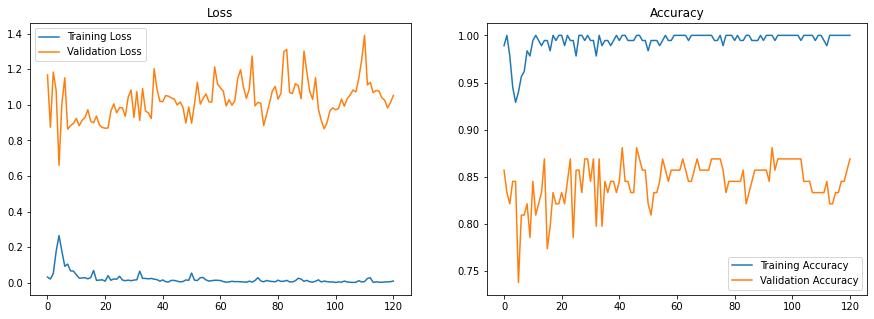

In [94]:
plot_metrics(history)

In [105]:

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(tf.keras.layers.Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())



ResourceExhaustedError: OOM when allocating tensor with shape[65536,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [103]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

NameError: name 'x_train' is not defined

## Part 4 - Making single predictions

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image


from IPython.display import display, Image
display(Image(filename='brain_tumor_dataset_splitted1/val/no/46 no.jpg'))
test_image = image.load_img('brain_tumor_dataset_splitted1/val/no/46 no.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
if result[0][0] == 1:
  prediction = 'Yes'
else:
  prediction = 'No'

print("Actual: No")
print("Predicted:", prediction)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image


from IPython.display import display, Image
display(Image(filename='brain_tumor_dataset_splitted1/val/yes/Y147.JPG'))
test_image = image.load_img('brain_tumor_dataset_splitted1/val/yes/Y147.JPG', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train.class_indices
if result[0][0] == 1:
  prediction = 'Yes'
else:
  prediction = 'No'

print("Actual: Yes")
print("Predicted:", prediction)